In [1]:
import os
import tensorflow as tf
import cv2
import csv
import shutil
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from sklearn.model_selection import train_test_split

In [2]:
height = 224
width = 224
imgs = []
blank_image = np.zeros((height,width), np.uint8)

In [3]:
#iris_dataset_preview
data = pd.read_csv('Iris.csv')
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
#clearing images
def clear_images(image):
    imgs.clear()
    if (os.path.exists('data')):
        shutil.rmtree('data')
    os.mkdir('data')
    os.mkdir('data/train')
    os.mkdir('data/test')
    os.mkdir('data/val')
clear_images(imgs) 

In [5]:
#create single SuperTML image from data
def create_tml_image(data_line):
    font = ImageFont.truetype('Arial.ttf', size = 40)
    tml_img = Image.new('RGB', (width, height), color = 'black')
    draw  = ImageDraw.Draw(tml_img)
    draw.text((36, 36), str(data_line['SepalLengthCm']), font=font, fill = (255, 255, 255))
    draw.text((130, 36), str(data_line['SepalWidthCm']), font=font, fill = (255, 255, 255))
    draw.text((36, 130), str(data_line['PetalWidthCm']), font=font, fill = (255, 255, 255))
    draw.text((130, 130), str(data_line['PetalLengthCm']), font=font, fill = (255, 255, 255))
    img_name = str(data_line['Id']) + '_' + data_line['Species'] + ".jpg"
    tml_img.save(os.path.join('data', img_name))
    imgs.append(img_name)
    img_display = Image.open(os.path.join('data', img_name), 'r')
    plt.imshow(np.asarray(img_display))

In [6]:
#create all SuperTML images for given data located at 'path_to_data'
def create_tml_image_total(path_to_data):
    data = pd.read_csv(path_to_data)
    counter= 0
    font = ImageFont.truetype('Arial.ttf', size = 40)
    for idx in data.index:
        counter+=1
        data_line = data.iloc[idx]
        tml_img = Image.new('RGB', (width, height), color = 'black')
        draw  = ImageDraw.Draw(tml_img)
        draw.text((36, 36), str(data_line['SepalLengthCm']), font=font, fill = (255, 255, 255))
        draw.text((130, 36), str(data_line['SepalWidthCm']), font=font, fill = (255, 255, 255))
        draw.text((36, 130), str(data_line['PetalWidthCm']), font=font, fill = (255, 255, 255))
        draw.text((130, 130), str(data_line['PetalLengthCm']), font=font, fill = (255, 255, 255))
        img_name = str(data_line['Id']) + "_" + data_line['Species'] + ".jpg"
        tml_img.save(os.path.join('data', img_name))
        imgs.append(img_name)
    print(counter)

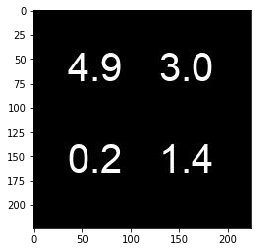

In [7]:
create_tml_image(data.iloc[1])

In [8]:
clear_images(imgs)
create_tml_image_total('Iris.csv')

150


In [9]:
train, test = train_test_split(imgs, test_size=0.2, random_state=1)
#train, val = train_test_split(train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [10]:
print(len(train))
print(len(test))
#print(len(val))

120
30


In [11]:
for image in train:
    if (not os.path.exists(os.path.join('data/train', image))):
        shutil.move(os.path.join('data', image), os.path.join('data', 'train'))
"""for image in val:
    if (not os.path.exists(os.path.join('data/val', image))):
        shutil.move(os.path.join('data', image), os.path.join('data', 'val'))"""
for image in test:
    if (not os.path.exists(os.path.join('data/test', image))):
        shutil.move(os.path.join('data', image), os.path.join('data', 'test'))

In [12]:
#creating labels
def create_label_dict(data):
    labels = {}
    index = 0 
    for idx in data.index:
        if (data.iloc[idx]['Species'] not in labels):
            labels[data.iloc[idx]['Species']] = index
            index+=1
    return labels
labels = create_label_dict(data)

In [13]:
#one-hot encoding of classes of Irises
def to_one_hot(labels, dimensions):
    results = np.zeros((len(labels), dimensions))
    for i, label in enumerate(labels):
        results[i, label] = 1
    return results
iris_labels = [0,1,2]
iris_one_hot = to_one_hot(iris_labels, 3)

#get the one-hot matrix of a given 'label'
def get_one_hot_encoding(label, label_dict):
    for key in label_dict:
        if (label==key):
            return iris_one_hot[label_dict[label]]
        
#create dictionary for one-hot encodings of labels
def create_one_hot_dict(one_hot, labels):
    final_dict = {}
    for i in labels:
        if (i not in final_dict):
            final_dict[i]=get_one_hot_encoding(i, labels)
    return final_dict

def get_label(val, one_hot_dict):
    for elem in one_hot_dict:
        comparison = (one_hot_dict[elem]==val)
        if (comparison.all()):
            return elem

In [14]:
one_hot_dict = create_one_hot_dict(get_one_hot_encoding('Iris-versicolor', labels), labels)
get_label(one_hot_dict['Iris-setosa'], one_hot_dict)
print(get_label(one_hot_dict['Iris-setosa'], one_hot_dict))

Iris-setosa


In [15]:
#creating images and label pairs
def create_labels(train, test):
    #val_labels = []
    test_labels = []
    train_labels = []
    #val_examples = []
    test_examples = []
    train_examples = []
    for image in train:
        label = image.split('_')[1][:(int(len(image.split('_')[1])-4))]
        vect = get_one_hot_encoding(label, labels)
        train_labels.append(vect)
        train_examples.append(mpimg.imread('data/train/' + image))
    for image in test:
        label = image.split('_')[1][:(int(len(image.split('_')[1])-4))]
        test_labels.append(get_one_hot_encoding(label, labels))
        test_examples.append(mpimg.imread('data/test/' + image))
    """for image in val:
        label = image.split('_')[1][:(int(len(image.split('_')[1])-4))]
        val_labels.append(get_one_hot_encoding(label, labels))
        val_examples.append(mpimg.imread('data/val/' + image))"""
    return test_labels, train_labels, test_examples, train_examples
    #return val_labels, test_labels, train_labels, val_examples, test_examples, train_examples
#val_labels, test_labels, train_labels, val_examples, test_examples, train_examples = create_labels(train, test, val)
test_labels, train_labels, test_examples, train_examples = create_labels(train, test)

In [16]:
def get_label_name(val):
    for vect in range(iris_one_hot.shape[1]):
        if val==iris_one_hot[:,vect]:
            return labels.get_key(vect)

<TensorSliceDataset shapes: ((224, 224, 3), (3,)), types: (tf.int32, tf.float64)>
<TensorSliceDataset shapes: ((224, 224, 3), (3,)), types: (tf.int32, tf.float64)>


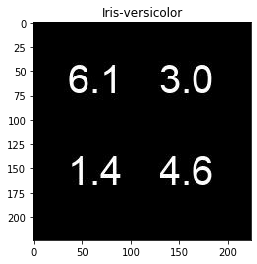

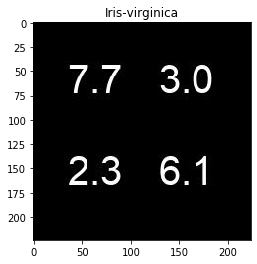

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))
#val_dataset = tf.data.Dataset.from_tensor_slices((val_examples, val_labels))
print(train_dataset)
print(test_dataset)
#print(val_dataset)

for image, label in train_dataset.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label(np.asarray(label), one_hot_dict))

In [18]:
IMG_SIZE = 160 # All images will be resized to 160x160
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label
train = train_dataset.map(format_example)
#validation = val_dataset.map(format_example)
test = test_dataset.map(format_example)

In [19]:
BATCH_SIZE = 30
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE)
train_batches = train_batches.batch(BATCH_SIZE)
#validation_batches = validation.shuffle(SHUFFLE_BUFFER_SIZE)
#validation_batches = validation_batches.batch(BATCH_SIZE)
test_batches = test.shuffle(SHUFFLE_BUFFER_SIZE)
test_batches = test_batches.batch(BATCH_SIZE)
for image_batch, label_batch in train_batches.take(1):
    pass
image_batch.shape

TensorShape([30, 160, 160, 3])

In [20]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False,weights='imagenet')

In [21]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(30, 5, 5, 1280)


In [22]:
#BEGIN
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [23]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(30, 1280)


In [24]:
dense_layer = tf.keras.layers.Dense(64, input_shape=(20, 1280))
dense = dense_layer(feature_batch_average)
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
prediction_batch = prediction_layer(dense)#prediction_batch = prediction_layer(dense)
print(prediction_batch.shape)

(30, 3)


In [25]:
model = tf.keras.Sequential([base_model, global_average_layer, dense_layer, prediction_layer])

In [26]:
base_learning_rate = 0.001
model.compile(optimizer=tf.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0,
                                                           name='categorical_crossentropy'
                                                          ),
              metrics=[tf.metrics.CategoricalAccuracy(name='accuracy')])

In [27]:
model.summary()
len(model.trainable_variables)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 2,340,163
Trainable params: 82,179
Non-trainable params: 2,257,984
_________________________________________________________________


4

In [31]:
initial_epochs = 50
#validation_steps= 4

#loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

In [32]:
"""print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))"""

'print("initial loss: {:.2f}".format(loss0))\nprint("initial accuracy: {:.2f}".format(accuracy0))'

In [33]:
history = model.fit(train_batches, epochs=initial_epochs)

Epoch 1/50
4/4 [==============================] - 1s 214ms/step - loss: 0.7472 - accuracy: 0.8417
Epoch 2/50
4/4 [==============================] - 1s 213ms/step - loss: 0.6901 - accuracy: 0.9083
Epoch 3/50
4/4 [==============================] - 1s 214ms/step - loss: 0.6805 - accuracy: 0.9167
Epoch 4/50
4/4 [==============================] - 1s 212ms/step - loss: 0.6824 - accuracy: 0.9000
Epoch 5/50
4/4 [==============================] - 1s 213ms/step - loss: 0.6747 - accuracy: 0.9083
Epoch 6/50
4/4 [==============================] - 1s 212ms/step - loss: 0.6852 - accuracy: 0.8917
Epoch 7/50
4/4 [==============================] - 1s 212ms/step - loss: 0.7335 - accuracy: 0.8250
Epoch 8/50
4/4 [==============================] - 1s 212ms/step - loss: 0.6621 - accuracy: 0.9333
Epoch 9/50
4/4 [==============================] - 1s 211ms/step - loss: 0.6543 - accuracy: 0.9083
Epoch 10/50
4/4 [==============================] - 1s 209ms/step - loss: 0.7034 - accuracy: 0.8583
Epoch 11/50
4/4 [==

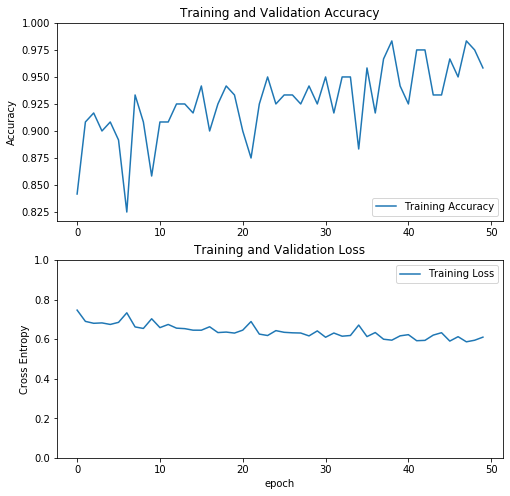

In [37]:
acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

loss = history.history['loss']
#val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
#plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  155


In [39]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0,
                                                           name='categorical_crossentropy'),
              optimizer = tf.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=[tf.metrics.CategoricalAccuracy(name='accuracy')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 2,340,163
Trainable params: 1,944,771
Non-trainable params: 395,392
_________________________________________________________________


In [40]:
len(model.trainable_variables)

60

In [42]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1])

Epoch 50/70
4/4 [==============================] - 1s 335ms/step - loss: 0.8848 - accuracy: 0.6583
Epoch 51/70
4/4 [==============================] - 1s 329ms/step - loss: 0.7143 - accuracy: 0.8417
Epoch 52/70
4/4 [==============================] - 1s 333ms/step - loss: 0.6621 - accuracy: 0.8917
Epoch 53/70
4/4 [==============================] - 1s 332ms/step - loss: 0.6159 - accuracy: 0.9417
Epoch 54/70
4/4 [==============================] - 1s 335ms/step - loss: 0.6049 - accuracy: 0.9500
Epoch 55/70
4/4 [==============================] - 1s 336ms/step - loss: 0.5895 - accuracy: 0.9583
Epoch 56/70
4/4 [==============================] - 1s 330ms/step - loss: 0.5870 - accuracy: 0.9583
Epoch 57/70
4/4 [==============================] - 1s 330ms/step - loss: 0.5782 - accuracy: 0.9750
Epoch 58/70
4/4 [==============================] - 1s 331ms/step - loss: 0.6031 - accuracy: 0.9500
Epoch 59/70
4/4 [==============================] - 1s 329ms/step - loss: 0.5810 - accuracy: 0.9667
Epoch 60/7

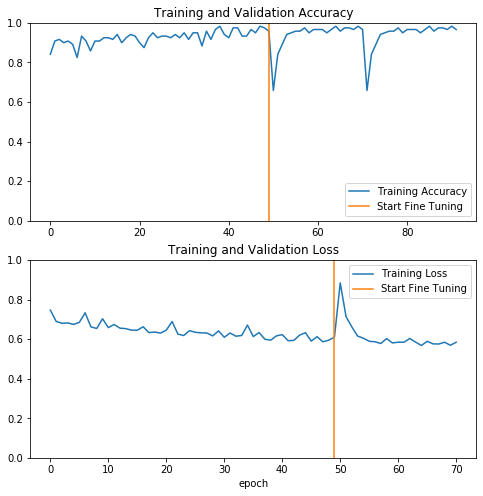

In [44]:
acc += history_fine.history['accuracy']
#val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
#val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
#plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [47]:
print("Evaluate on test data")
results = model.evaluate(test_batches)
print("test loss, test acc:", results)

Evaluate on test data
1/1 [==============================] - 0s 790us/step - loss: 1.2880 - accuracy: 0.2333
test loss, test acc: [1.2880488634109497, 0.23333333432674408]


In [251]:
def test_images(num_images, test_batches):
    print("Generate predictions for 3 samples")
    predictions = model.predict(test_batches)
    print(predictions[:3])
    imgs_to_test = []
    test_labels = []
    for image, label in test_batches:
        for i in range(num_images):
            imgs_to_test.append(image[i])
            test_labels.append(get_label(np.asarray(label[i]), one_hot_dict))
        break
    final_preds = []
    for preds in predictions[:3]:
        max_prob = 0
        pred = 0
        for i in range(preds.shape[0]):
            if (preds[i] > max_prob):
                max_prob = preds[i]
                pred = i
        final_pred = np.zeros((3,))
        final_pred[pred] = 1
        final_preds.append(get_label(final_pred, one_hot_dict))
    print(final_preds)
    print(test_labels)

In [252]:
test_images(3, test_batches)

Generate predictions for 3 samples
[[0.4414446  0.04095106 0.5176043 ]
 [0.07470609 0.01540832 0.9098856 ]
 [0.6055602  0.06530403 0.32913578]]
['Iris-virginica', 'Iris-virginica', 'Iris-setosa']
['Iris-virginica', 'Iris-setosa', 'Iris-versicolor']


In [255]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_batches)
print("test loss, test acc:", results)

Evaluate on test data
2/2 [==============================] - 0s 51ms/step - loss: 1.1615 - accuracy: 0.2667
test loss, test acc: [1.161512017250061, 0.2666666805744171]
